In [1]:
import pandas as pd
import numpy as np
import boto3, os, sys, io

# Viz
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import findspark
import configparser

# Features extraction
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
BUCKET_NAME = 'fruitbucketoc'
PREFIX = 'Imgs'

In [3]:
model = ResNet50(include_top=False)

# Check env variables

In [4]:
findspark.init()
# Sets environment variables and adds dependencies to sys.path.
# If no Spark location is provided, will try to find an installation.

In [5]:
print('SPARK_HOME: ', os.environ['SPARK_HOME'])

SPARK_HOME:  /home/ubuntu/spark-3.0.3-bin-hadoop2.7


In [6]:
os.environ.get('PYSPARK_PYTHON')

'/home/ubuntu/anaconda3/bin/python'

In [7]:
os.environ.get('PYSPARK_SUBMIT_ARGS')

# Connection EC2 -> S3

In [8]:
connexion = boto3.client('s3')
contents = connexion.list_objects(Bucket=BUCKET_NAME, Prefix=PREFIX)['Contents']
for file in contents:
    print(file['Key']) 

Imgs/
Imgs/Fig/
Imgs/Fig/0_100.jpg
Imgs/Fig/r2_213_100.jpg
Imgs/Fig/r2_305_100.jpg
Imgs/Fig/r2_75_100.jpg
Imgs/Fig/r_15_100.jpg
Imgs/Kaki/
Imgs/Kaki/12_100.jpg
Imgs/Kaki/88_100.jpg
Imgs/Kaki/r_0_100.jpg
Imgs/Kaki/r_326_100.jpg
Imgs/Kaki/r_96_100.jpg
Imgs/Kiwi/
Imgs/Kiwi/0_100.jpg
Imgs/Kiwi/r_105_100.jpg
Imgs/Kiwi/r_13_100.jpg
Imgs/Kiwi/r_159_100.jpg
Imgs/Kiwi/r_315_100.jpg
Imgs/Mango/
Imgs/Mango/13_100.jpg
Imgs/Mango/95_100.jpg
Imgs/Mango/r_153_100.jpg
Imgs/Mango/r_327_100.jpg
Imgs/Mango/r_38_100.jpg
Imgs/Peach/
Imgs/Peach/0_100.jpg
Imgs/Peach/114_100.jpg
Imgs/Peach/r_174_100.jpg
Imgs/Peach/r_252_100.jpg
Imgs/Peach/r_28_100.jpg


# Init Spark

In [9]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.2 pyspark-shell'

- Retrieve aws [default] credentials stored in our local machine

In [10]:
aws_profile = "default"

config = configparser.ConfigParser()
config.read(os.path.expanduser("~/.aws/credentials"))
access_id = config.get(aws_profile, "aws_access_key_id") 
secret_key = config.get(aws_profile, "aws_secret_access_key")

- Init SparkSession (The entry point to underlying PySpark functionality in order to programmatically create PySpark RDD, DataFrame)

Notes on S3: <br>


    S3 Native FileSystem (URI scheme: s3n) Native filesystem for reading and writing regular files on S3.
    Can access files on S3 that were written with other tools. Conversely, other tools can access files written using Hadoop. The disadvantage is the 5GB limit on file size imposed by S3.

    S3A (URI scheme: s3a) Successor to S3 Native, allow interaction with S3. Filesystem intended to be a replacement for/successor to S3 Native
    - Support Larger Files (no more 5GB limit),
    - higher performance operations and more. 

    S3 Block FileSystem (URI scheme: s3) A block-based filesystem backed by S3. Files are stored as blocks, like HDFS. 
    This permits efficient implementation of renames. 
    This filesystem requires you to dedicate a bucket for the filesystem - you should not use an existing bucket containing files, or write other files to the same bucket. 
    The files stored by this filesystem can be larger than 5GB, but they are not interoperable with other S3 tools.


In [11]:
spark = (SparkSession
         .builder.master('local[*]') # Run in local with as many workers as logical cores
         .appName('P8')
         .config('spark.hadoop.fs.s3a.access.key', access_id) 
         .config('spark.hadoop.fs.s3a.secret.key', secret_key) 
         .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
         .getOrCreate() # returns a SparkSession object if already exists, creates new one if not.
        )

- Init SparkContext (Object that tells how to access a cluster)

In [12]:
sc = spark.sparkContext
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.us-east-1.amazonaws.com")

- Retrieve our img dataframe

In [13]:
s3_url = f"s3a://{BUCKET_NAME}/{PREFIX}/*"
df = spark.read.format("binaryfile").load(s3_url)

In [14]:
df.show(5)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3a://fruitbucket...|2021-12-17 13:07:20|  5336|[FF D8 FF E0 00 1...|
|s3a://fruitbucket...|2021-12-17 13:07:18|  5251|[FF D8 FF E0 00 1...|
|s3a://fruitbucket...|2021-12-17 13:07:19|  5190|[FF D8 FF E0 00 1...|
|s3a://fruitbucket...|2021-12-17 13:07:18|  5126|[FF D8 FF E0 00 1...|
|s3a://fruitbucket...|2021-12-17 13:07:18|  5124|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows



In [15]:
df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



- We need to create a label column and delete length and modificationTime

In [16]:
from pyspark.sql.functions import split

In [17]:
df = df.withColumn('label', split(df.path, '/').getItem(4))
df = df.select('path', 'content', 'label')
df.show(5)

+--------------------+--------------------+-----+
|                path|             content|label|
+--------------------+--------------------+-----+
|s3a://fruitbucket...|[FF D8 FF E0 00 1...| Kaki|
|s3a://fruitbucket...|[FF D8 FF E0 00 1...|Peach|
|s3a://fruitbucket...|[FF D8 FF E0 00 1...| Kiwi|
|s3a://fruitbucket...|[FF D8 FF E0 00 1...|Peach|
|s3a://fruitbucket...|[FF D8 FF E0 00 1...|Peach|
+--------------------+--------------------+-----+
only showing top 5 rows



# Feature extraction

Spark workers need to access the model and its weights.

   - For moderately sized models (< 1GB in size), a good practice is to download the model to the Spark driver and then broadcast the weights to the workers. This notebook uses this approach.
   - For large models (> 1GB), it is best to load the model weights from distributed storage to workers directly.


Used this code: https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html

In [18]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [19]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

In [20]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/ubuntu/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [21]:
features_df = df.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [22]:
features_df.show(5)

+--------------------+-----+--------------------+
|                path|label|            features|
+--------------------+-----+--------------------+
|s3a://fruitbucket...| Kaki|[0.0, 0.0, 0.0, 0...|
|s3a://fruitbucket...|Peach|[0.0, 0.0, 0.0, 0...|
|s3a://fruitbucket...| Kiwi|[0.0, 0.0, 0.0, 0...|
|s3a://fruitbucket...|Peach|[0.0, 0.0, 0.0, 0...|
|s3a://fruitbucket...|Peach|[0.0, 0.0, 0.0, 0...|
+--------------------+-----+--------------------+
only showing top 5 rows



# PCA

## Preprocessing

In [23]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

- We scale the input to the PCA

In [24]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

In [25]:
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='features_scaled')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [26]:
features_df_scaled.show(5) 

+--------------------+-----+--------------------+--------------------+
|                path|label|            features|     features_scaled|
+--------------------+-----+--------------------+--------------------+
|s3a://fruitbucket...| Kaki|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://fruitbucket...|Peach|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://fruitbucket...| Kiwi|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://fruitbucket...|Peach|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|s3a://fruitbucket...|Peach|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



## Transformation

In [27]:
pca = PCA(k=10, inputCol="features_scaled", outputCol="pca")
model_pca = pca.fit(features_df_scaled)
transformed = model_pca.transform(features_df_scaled)

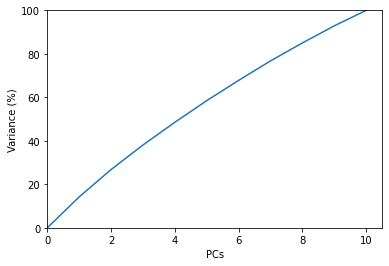

In [28]:
to_disp = model_pca.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(11)], y=np.insert(to_disp,0,0)*100)
plt.xlabel('PCs')
plt.ylabel('Variance (%)')
plt.ylim(0,100)
plt.xlim(left=0)
plt.show()

# Export

In [29]:
transformed_final = transformed.select('path', 'label', 'pca')
transformed_pandas = transformed_final.toPandas()

In [35]:
path_to_save = f's3://{BUCKET_NAME}/{PREFIX}/PCA_out.parquet.gzip'
transformed_pandas.astype({'pca': str}).to_parquet(path_to_save, compression='gzip', index=False)

---

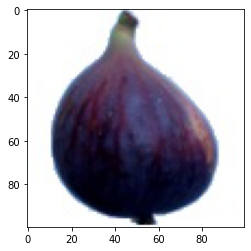

In [39]:
img = mpimg.imread(file_name)
plt.imshow(img)
plt.show()